# Price Predictions of Second-Hand Kia Sorento (Ongoing)

I want to optimize my search for second-hand cars using data science.

One of the strongest contenders is the Kia Sorento.

## 0. Preparation

In [1]:
# Import libraries
from selenium import webdriver
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

In [2]:
chrome_path = r"C:\yourpath\chromedriver_win32\chromedriver.exe"
driver = webdriver.Chrome(chrome_path)

## 1. Collecting data
### Collecting data on Kia Sorento from Carmax.com (500 cars)
I am limiting my search to five-year old cars (2013-2017).

In [3]:
title_list = []
price_list = []
mileage_list = []

for i in range(1,11):
    url = 'https://www.carmax.com/search#Distance=all&ExposedCategories=249+250+1001+1000+265+999+772&ExposedDimensions=249+250+1001+1000+265+999+772&FreeText=kia%20sorento&MaxYear=2018&MinYear=2013&Page=' + str(i) + '&PerPage=50&SortKey=0&Zip=92618'
    driver.get(url)
    titles = driver.find_elements_by_class_name("vehicle-browse--result-title-description")
    for title in titles:
        title_list.append(title.text)
    # Remove 'empty titles' 
    title_list = [title for title in title_list if title != '']
    
    prices = driver.find_elements_by_class_name("vehicle-browse--result-price")
    for price in prices:
        price_list.append(price.text)
    
    mileages = driver.find_elements_by_class_name("vehicle-browse--result-mileage")
    for mileage in mileages:
        mileage_list.append(mileage.text)

In [4]:
# Create dataframe from the lists
cars = pd.DataFrame({'Title': title_list, 'Price': price_list, 'Mileage': mileage_list})
print(cars.shape)
print(cars.head(10))

(500, 3)
  Mileage   Price                Title
0     62K  15,599  2013 Kia Sorento LX
1     75K  14,998  2014 Kia Sorento LX
2     22K  20,998  2016 Kia Sorento LX
3     41K  17,599  2014 Kia Sorento LX
4     41K  20,998  2016 Kia Sorento LX
5     36K  18,998  2015 Kia Sorento LX
6     42K  16,599  2015 Kia Sorento LX
7     19K  18,998  2015 Kia Sorento LX
8     32K  19,599  2015 Kia Sorento LX
9     34K  19,998  2016 Kia Sorento LX


### Cleaning the data

In [5]:
# Split the title column into 4 columns
cars[['Year','Brand', 'Model', 'Trim']] = cars.Title.str.rsplit(n=4, expand=True)
del cars['Title']
print(cars.head(10))

  Mileage   Price  Year Brand    Model Trim
0     62K  15,599  2013   Kia  Sorento   LX
1     75K  14,998  2014   Kia  Sorento   LX
2     22K  20,998  2016   Kia  Sorento   LX
3     41K  17,599  2014   Kia  Sorento   LX
4     41K  20,998  2016   Kia  Sorento   LX
5     36K  18,998  2015   Kia  Sorento   LX
6     42K  16,599  2015   Kia  Sorento   LX
7     19K  18,998  2015   Kia  Sorento   LX
8     32K  19,599  2015   Kia  Sorento   LX
9     34K  19,998  2016   Kia  Sorento   LX


In [6]:
# Convert years to integers
cars['Year'] = [int(x) for x in cars[ 'Year']] 

In [7]:
# Remove comma separator in the price column and convert to numeric
cars['Price'] = cars['Price'].map(lambda x: x.replace(',', ''))
cars['Price'] = pd.to_numeric(cars['Price'], errors = 'coerce', downcast = 'integer')

In [8]:
# Remove thousand indicator ('K') in the mileage column and convert to numeric
cars['Mileage'] = cars['Mileage'].map(lambda x: x.rstrip('K'))
cars['Mileage'] = pd.to_numeric(cars['Mileage'], errors = 'coerce', downcast = 'integer')

In [9]:
cars.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
Mileage    500 non-null int8
Price      500 non-null int32
Year       500 non-null int64
Brand      500 non-null object
Model      500 non-null object
Trim       500 non-null object
dtypes: int32(1), int64(1), int8(1), object(3)
memory usage: 95.9 KB


## 2. Analyzing the Data
### Trims

In [10]:
# Get all the unique trims
sorento_trim = list(cars['Trim'].unique())
print(sorento_trim)

['LX', 'Limited', 'SX', 'EX', 'L']


In [11]:
l_sorento = cars[cars['Trim'] == 'L']
l_sorento = l_sorento.reset_index(drop = True)
lx_sorento = cars[cars['Trim'] == 'LX']
lx_sorento = lx_sorento.reset_index(drop = True)
ex_sorento = cars[cars['Trim'] == 'EX']
ex_sorento = ex_sorento.reset_index(drop = True)
limited_sorento = cars[cars['Trim'] == 'Limited']
limited_sorento = limited_sorento.reset_index(drop = True)
sx_sorento = cars[cars['Trim'] == 'SX']
sx_sorento = sx_sorento.reset_index(drop = True)

print(l_sorento.shape)
print(lx_sorento.shape)
print(ex_sorento.shape)
print(limited_sorento.shape)
print(sx_sorento.shape)

(8, 6)
(427, 6)
(19, 6)
(21, 6)
(25, 6)


The majority (over 85%) of used Kia Sorento on sale at Carmax are Sorento LX. A quick search on other used cars websites shows that this is common: Edmunds.com (more than 75% of the inventory of Kia Sorento is of trim LX) and Cars.com (more than 65%). On the three websites, the most common used Kia Sorento after the LX trim, are EX and SX. There are only a handful of L, SXL and Limited.

- The L and LX trims are the base models and correspond to 185 HP.
- The EX trim corresponds to 240 HP.
- The SX and SXL models correspond to 290 HP.

### Price per year and mileage

In [12]:
color_dict = {2013: 'yellowgreen', 2014: 'orange', 2015: 'blue', 2016: 'magenta', 2017: 'cyan'}

In [13]:
def plot_price(df, trim):
    fig, ax = plt.subplots(figsize = (15,10))
    plt.scatter(df['Mileage'], df['Price'], 
                c = [color_dict[i] for i in df['Year']], 
                )
    #ax.set_xlim(-5000,125000)
    #ax.set_ylim(10000,35000)

    year_range = (2017,2016,2015,2014,2013) 
    recs = []
    for i in year_range:
        recs.append(mpatches.Rectangle((2,2),1,1,fc=color_dict[i]))
        plt.legend(recs,year_range,loc=1, fontsize = 16)

    plt.title('Price of Used Kia Sorento {0} per Mileage and Year\n(Source: {1} cars on Carmax.com)\n'.format(trim, len(df)), 
              fontsize = 20)
    plt.ylabel('Price', fontsize = 16)
    plt.xlabel('Mileage', fontsize = 16)

    xvals = ax.get_xticks()
    ax.set_xticklabels(['{}k'.format(int(x)) for x in xvals])
    
    yvals = ax.get_yticks()
    ax.set_yticklabels(['{:,}k'.format(int(y/1000)) for y in yvals])

    plt.show()

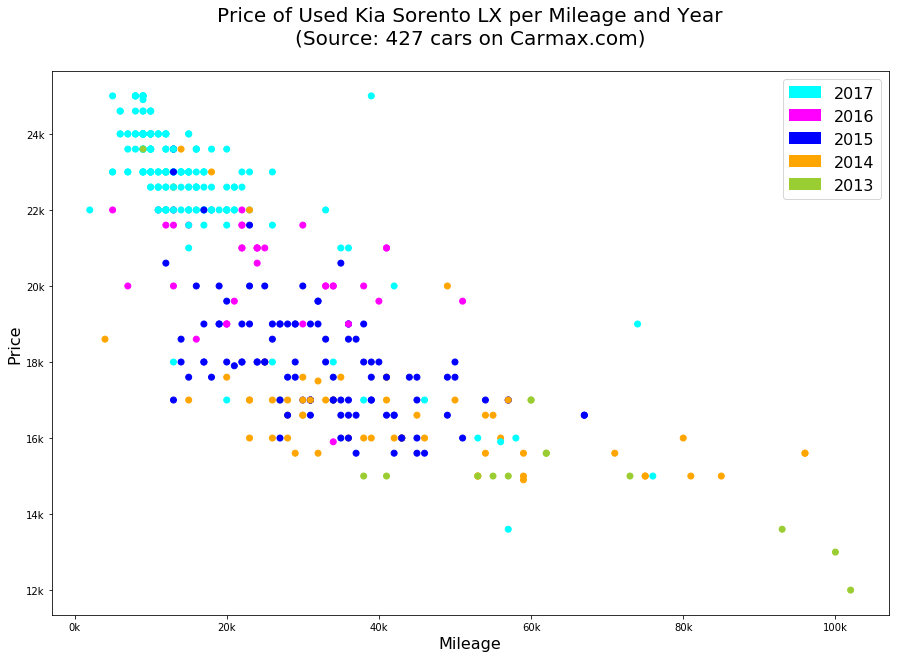

In [14]:
plot_price(lx_sorento, 'LX')

In [15]:
def plot_price_with_best_fit_line(df, trim):
    fig, ax = plt.subplots(figsize = (15,10))
    
    plt.plot(np.unique(df['Mileage']), np.poly1d(np.polyfit(df['Mileage'], df['Price'], 1))(np.unique(df['Mileage'])), 
             c = 'red',
             linewidth = 3)
    
    plt.scatter(df['Mileage'], df['Price'], 
                c = [color_dict[i] for i in df['Year']], 
                )

    year_range = (2017,2016,2015,2014,2013) 
    recs = []
    for i in year_range:
        recs.append(mpatches.Rectangle((2,2),1,1,fc=color_dict[i]))
        plt.legend(recs,year_range,loc=1, fontsize = 16)

    plt.title('Price of Used Kia Sorento {0} per Mileage and Year\n(Source: {1} cars on Carmax.com)\n'.format(trim, len(df)), 
              fontsize = 20)
    plt.ylabel('Price', fontsize = 16)
    plt.xlabel('Mileage', fontsize = 16)

    xvals = ax.get_xticks()
    ax.set_xticklabels(['{}k'.format(int(x)) for x in xvals])
    
    yvals = ax.get_yticks()
    ax.set_yticklabels(['{:,}k'.format(int(y/1000)) for y in yvals])

    plt.show()

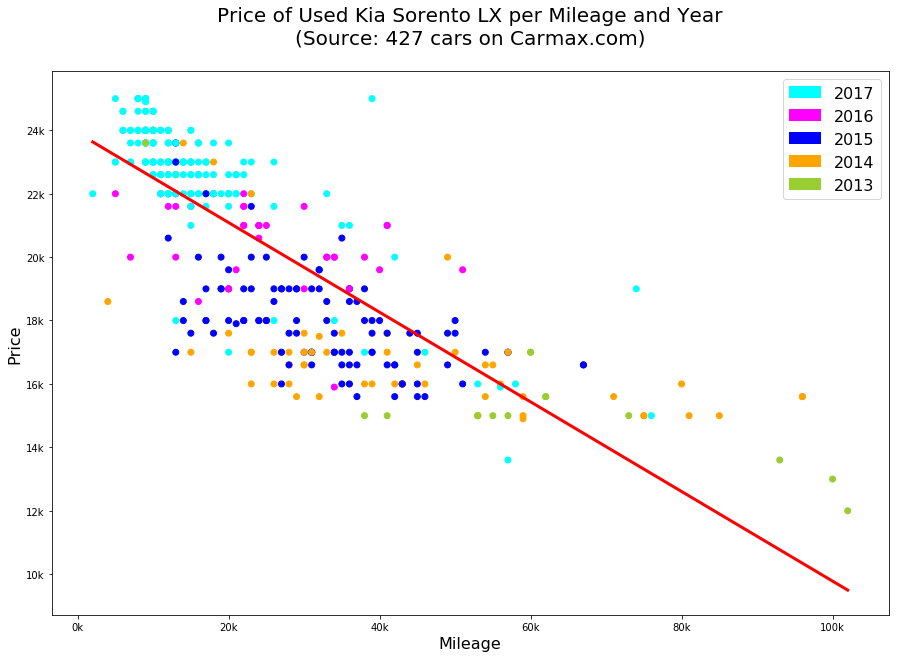

In [16]:
plot_price_with_best_fit_line(lx_sorento, 'LX')

In [17]:
def plot_price_with_best_fit_lines(df, trim):
    fig, ax = plt.subplots(figsize = (15,10))
    for year in color_dict:
        df_year = df[df['Year'] == year]
        
        if len(df_year) == 0:
            pass
        
        else:
        
            plt.plot(np.unique(df_year['Mileage']), 
                     np.poly1d(np.polyfit(df_year['Mileage'], df_year['Price'], 1))(np.unique(df_year['Mileage'])), 
                     c = color_dict[year],
                     linewidth = 3)
        
            plt.scatter(df_year['Mileage'], 
                        df_year['Price'], 
                        c = color_dict[year], 
                        )

    year_range = (2017,2016,2015,2014,2013) 
    recs = []
    for i in year_range:
        recs.append(mpatches.Rectangle((2,2),1,1,fc=color_dict[i]))
        plt.legend(recs,year_range,loc=1, fontsize = 16)

    plt.title('Price of Used Kia Sorento {0} per Mileage and Year\n(Source: {1} cars on Carmax.com)\n'.format(trim, len(df)), 
              fontsize = 20)
    plt.ylabel('Price', fontsize = 16)
    plt.xlabel('Mileage', fontsize = 16)

    xvals = ax.get_xticks()
    ax.set_xticklabels(['{}k'.format(int(x)) for x in xvals])
    
    yvals = ax.get_yticks()
    ax.set_yticklabels(['{:,}k'.format(int(y/1000)) for y in yvals])

    plt.show()

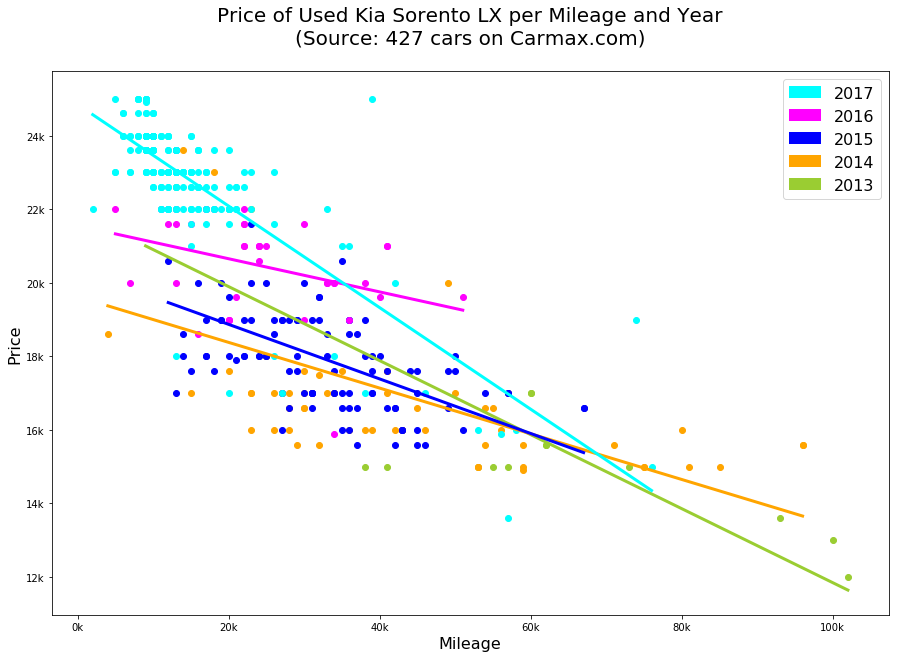

In [18]:
plot_price_with_best_fit_lines(lx_sorento, 'LX')

C:\Conda\lib\site-packages\ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


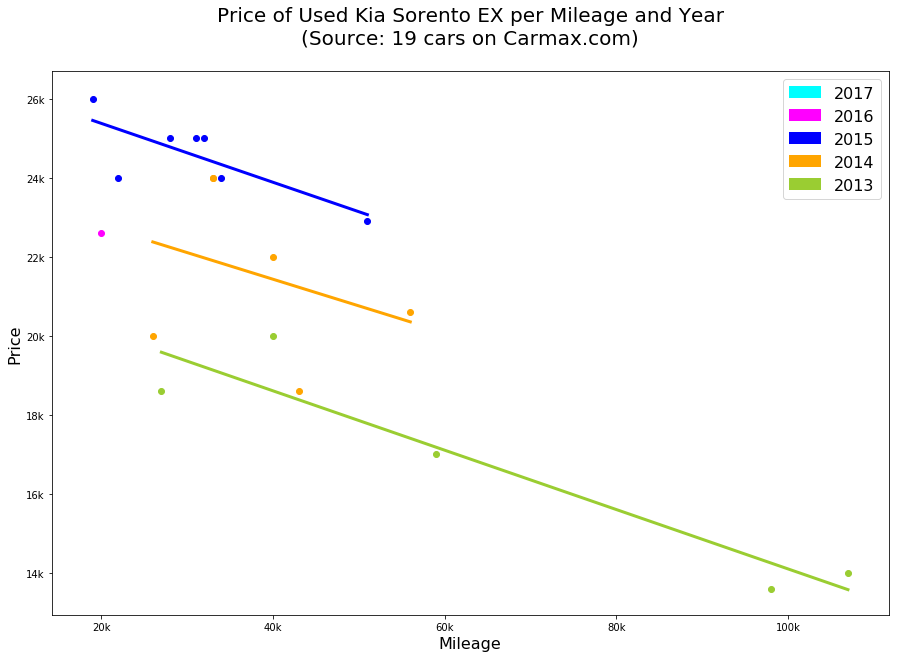

In [19]:
plot_price_with_best_fit_lines(ex_sorento, 'EX')

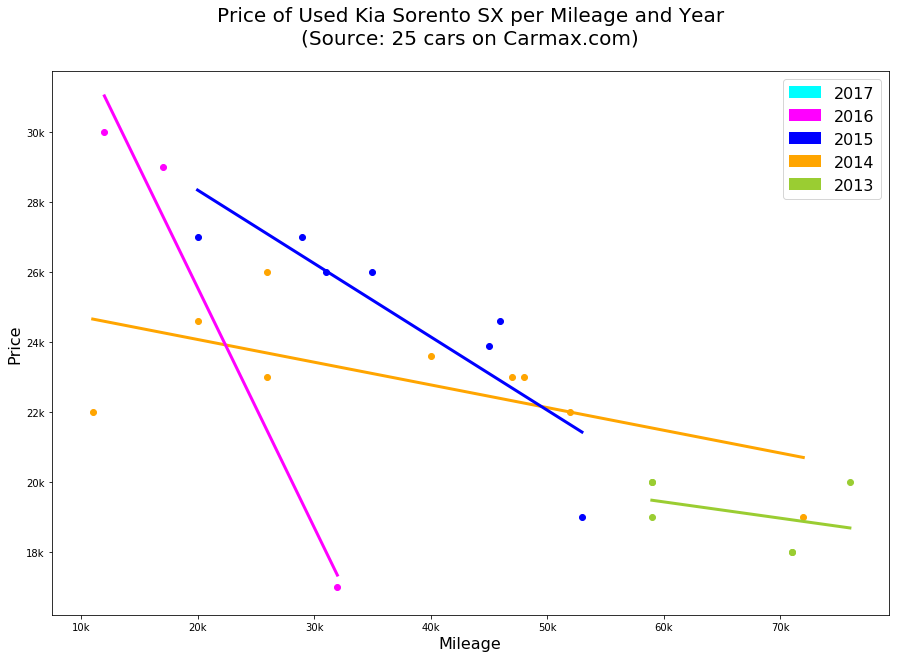

In [20]:
plot_price_with_best_fit_lines(sx_sorento, 'SX')

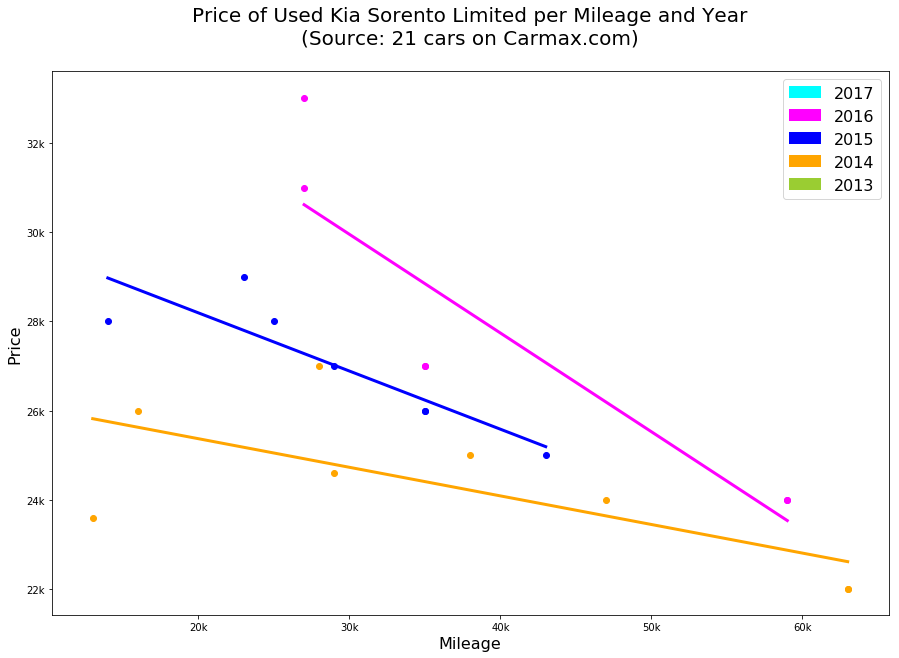

In [21]:
plot_price_with_best_fit_lines(limited_sorento, 'Limited')

These graphs clearly show that for a given mileage, newer cars tend to be more expensive.

The steeper negative slope of 2017 Kia Sorento LX seems to indicate that they lose value faster than older cars.

## 3. Creating Prediction Models
#### Create dummy variables for the year column

In [22]:
dummy_year = pd.get_dummies(lx_sorento['Year'], prefix = 'year')
lx_sorento = pd.concat([lx_sorento, dummy_year], axis=1)

print(lx_sorento.shape)
print(lx_sorento.head())

(427, 11)
   Mileage  Price  Year Brand    Model Trim  year_2013  year_2014  year_2015  \
0       62  15599  2013   Kia  Sorento   LX          1          0          0   
1       75  14998  2014   Kia  Sorento   LX          0          1          0   
2       22  20998  2016   Kia  Sorento   LX          0          0          0   
3       41  17599  2014   Kia  Sorento   LX          0          1          0   
4       41  20998  2016   Kia  Sorento   LX          0          0          0   

   year_2016  year_2017  
0          0          0  
1          0          0  
2          1          0  
3          0          0  
4          1          0  


In [23]:
features = ['Mileage', 'year_2013', 'year_2014', 'year_2015', 'year_2016', 'year_2017']

#### Split data into training and test sets

In [24]:
shuffled_rows = np.random.permutation(lx_sorento.index)
shuffled_lx_sorento = lx_sorento.iloc[shuffled_rows]
lim = int(0.7*len(lx_sorento))
train = shuffled_lx_sorento[:lim]
test = shuffled_lx_sorento[lim:]
print(train.shape)
print(test.shape)

(298, 11)
(129, 11)


#### Linear Regression Model

In [25]:
lr = LinearRegression()

In [26]:
# Train the model
lr.fit(train[features],train[['Price']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
# Make predictions
predictions = lr.predict(test[features])

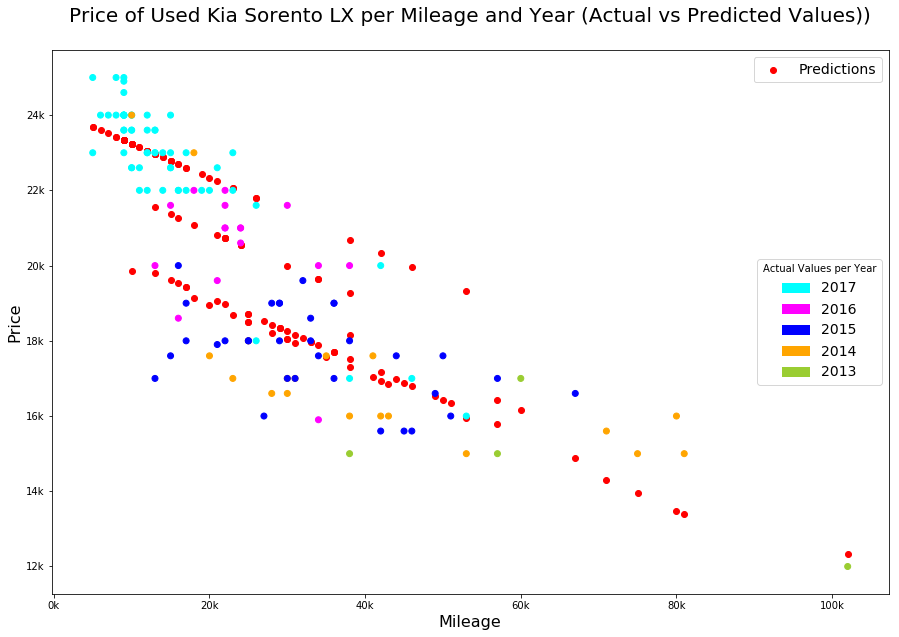

In [28]:
# Plot actual values vs. predictions
fig, ax = plt.subplots(figsize = (15,10))

ax.scatter(test['Mileage'], predictions, c = 'red', label = 'Predictions')

predictions_legend = plt.legend(fontsize = 14)
plt.gca().add_artist(predictions_legend)

ax.scatter(test['Mileage'], test['Price'], c = [color_dict[i] for i in test['Year']])

year_range = (2017,2016,2015,2014,2013) 
recs = []
for i in year_range:
    recs.append(mpatches.Rectangle((2,2),1,1,fc=color_dict[i]))
    plt.legend(recs,year_range,loc=7, fontsize = 14, title = 'Actual Values per Year')
    
plt.title('Price of Used Kia Sorento LX per Mileage and Year (Actual vs Predicted Values))\n', 
              fontsize = 20)

plt.ylabel('Price', fontsize = 16)
plt.xlabel('Mileage', fontsize = 16)

xvals = ax.get_xticks()
ax.set_xticklabels(['{}k'.format(int(x)) for x in xvals])
   
yvals = ax.get_yticks()
ax.set_yticklabels(['{:,}k'.format(int(y/1000)) for y in yvals])

plt.show()

In [29]:
print(lr.intercept_)

[ 22047.99731795]


In [30]:
print(lr.coef_)

[[  -91.00696202  -429.24127664 -1283.64194565 -1068.30350246
    679.98824559  2101.19847916]]


The formula to predict price is thus:

- If year is 2013: 20,175 - 46 * mileage (in thousand miles) - 2400 
- If year is 2014: 20,175 - 46 * mileage (in thousand miles) - 1518 
- If year is 2015: 20,175 - 46 * mileage (in thousand miles) - 1092 
- If year is 2016: 20175 - 46 * mileage (in thousand miles) + 1499 
- If year is 2017: 20175 - 46 * mileage (in thousand miles) + 3512 

In [31]:
#R2 score
print(lr.score(test[features], test[['Price']]))

0.820732237918


## 4. Next Steps (ongoing)

- Collect data from Cars.com or Edmunds.com to get more features (e.g., color, drivetrain: FWD/AWD) which might explain some of the price variance for a given trim, year and mileage.

- Create separate linear regression models for each year since the slope (price vs. mileage) seems different for each year.

- Use the models to identify potential good deals!